# Customer Segmentation Analysis

This notebook performs a customer segmentation analysis using the RFM (Recency, Frequency, Monetary) model and compares the performance of k-means clustering with hierarchical clustering. The goal is to identify different customer segments for targeted marketing strategies.

## 1. Introduction and Data Import
In this section, I import the necessary libraries and load the customer transaction data.

First, I will load the required libraries for data manipulation, visualization, and clustering. Then, I will read the transaction and customer datasets and merge them on the `CustomerID` column to create a comprehensive dataset for analysis.


In [2]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.cluster import KMeans, AgglomerativeClustering  # For k-means and hierarchical clustering
from sklearn.metrics import silhouette_score  # For evaluating clustering performance
from scipy.cluster.hierarchy import dendrogram, linkage  # For hierarchical clustering

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Load data from CSV and Excel files for analysis
df_sales = pd.read_csv('../data/Online_Sales.csv')  # Ensure this is the correct path and file name
df_customers = pd.read_excel('../data/CustomersData.xlsx')  # Ensure this is the correct path and file name

# Merge the datasets on 'CustomerID'
df_merged = pd.merge(df_sales, df_customers, on='CustomerID', how='inner')

# Display the first few rows of the merged dataset
df_merged.head()

# Display the column names to verify
print(df_merged.columns)



Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months'],
      dtype='object')


## 2. Data Preprocessing
In this step, I check for missing values, convert data types, and create a new feature called `TotalPrice` to facilitate further analysis.

Data preprocessing is a crucial step to ensure the dataset is clean and ready for analysis. Here, I will:
1. Check for missing values and drop rows with missing data.
2. Convert necessary columns to appropriate data types.
3. Create a new feature `TotalPrice` by multiplying the quantity and unit price of each transaction.


In [4]:
# Check for missing values in the dataset
df_merged.isnull().sum()

# Drop rows with missing values
df_merged.dropna(inplace=True)

# Verify no missing values remain
df_merged.isnull().sum()

# Convert necessary columns to appropriate data types (if required)
df_merged['Transaction_Date'] = pd.to_datetime(df_merged['Transaction_Date'])  # Convert 'Transaction_Date' to datetime format
df_merged['CustomerID'] = df_merged['CustomerID'].astype('str')  # Convert 'CustomerID' to string

# Create new feature: 'TotalPrice' as quantity * unit price
df_merged['TotalPrice'] = df_merged['Quantity'] * df_merged['Avg_Price']

# Verify the first few rows of the modified dataset
df_merged.head()

# Check for any remaining missing values
print(df_merged.isnull().sum())


CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Gender                 0
Location               0
Tenure_Months          0
TotalPrice             0
dtype: int64


## 3. Exploratory Data Analysis (EDA)
Here, I explore the data by plotting the distribution of total prices and quantities to understand the data distribution and detect any anomalies.

EDA helps to understand the underlying patterns and distributions in the dataset. I will generate descriptive statistics and visualize the distribution of total prices and quantities to identify any outliers or anomalies. Additionally, I will create plots to explore the relationships between different features.


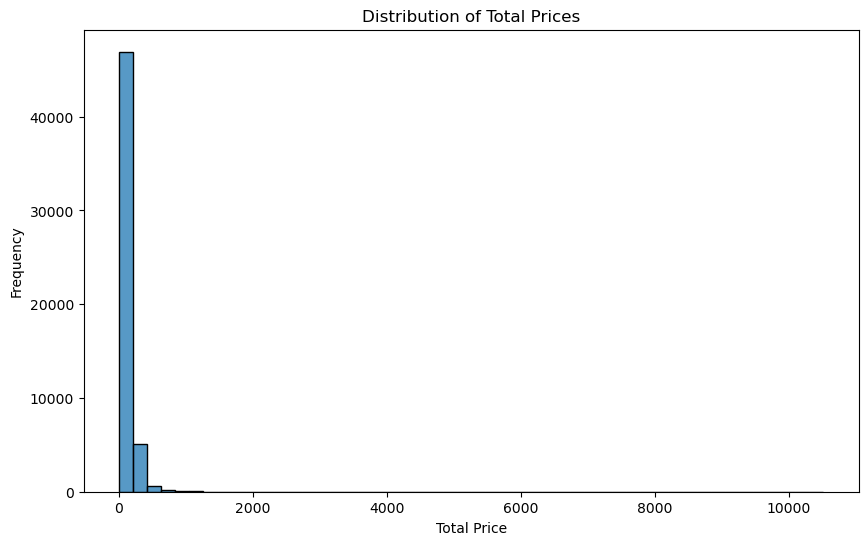

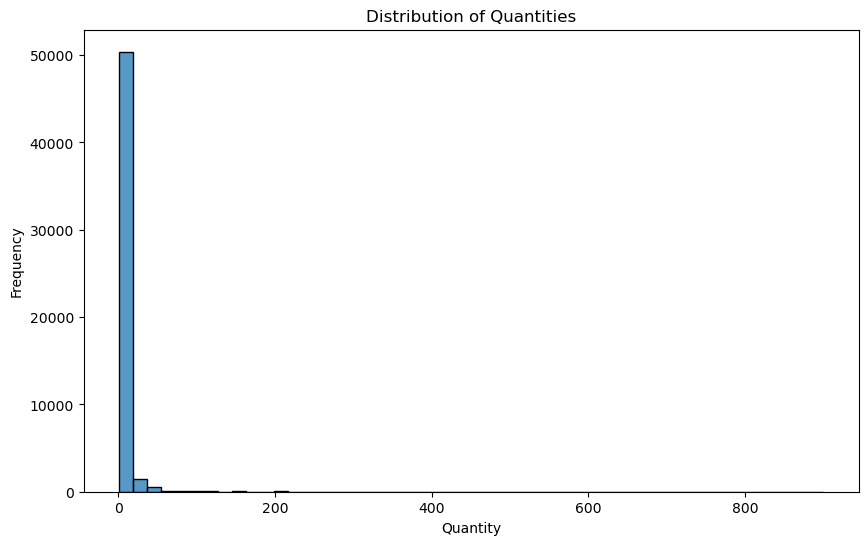

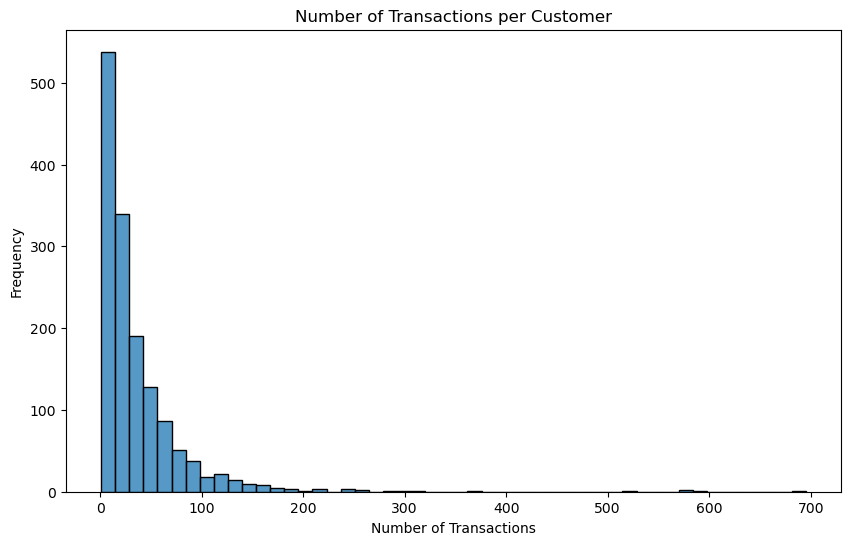

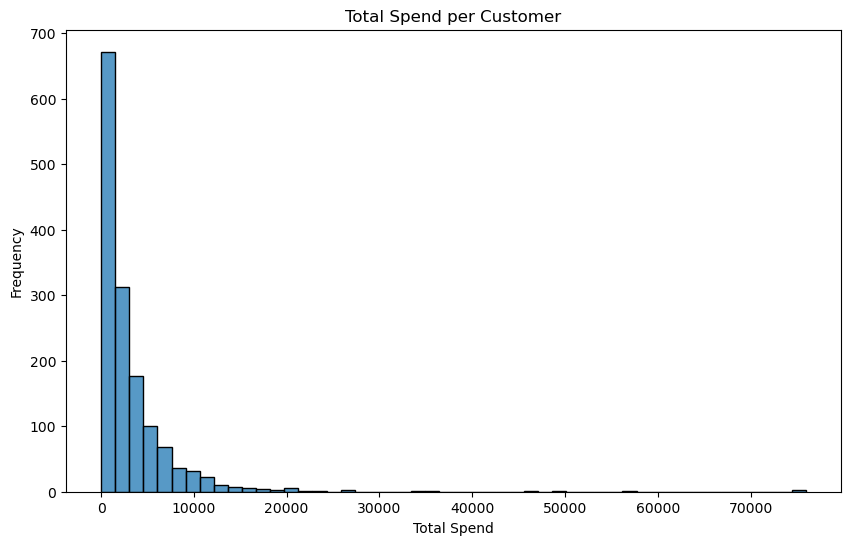

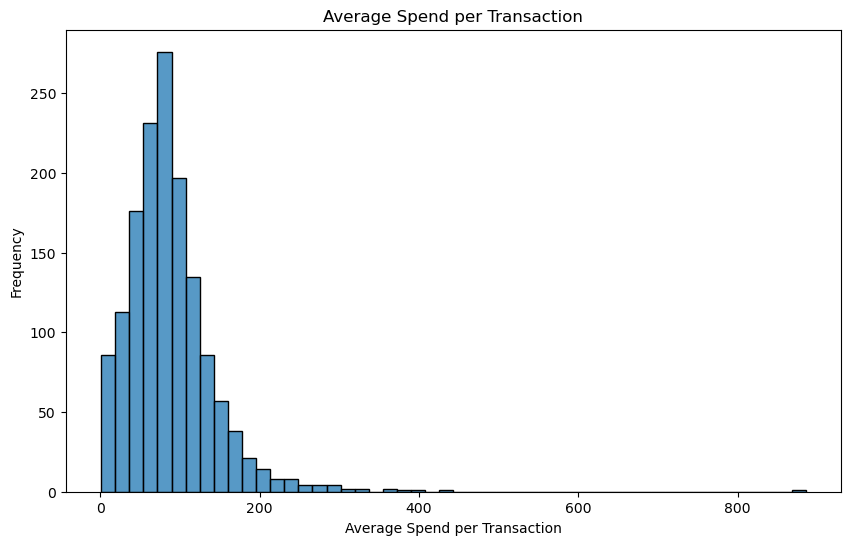

In [6]:
# Descriptive statistics for the dataset
df_merged.describe()

# Plot the distribution of total prices
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(df_merged['TotalPrice'], bins=50)  # Plot the distribution of 'TotalPrice'
plt.title('Distribution of Total Prices')  # Set the title of the plot
plt.xlabel('Total Price')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.show()  # Display the plot

# Plot the distribution of quantities
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(df_merged['Quantity'], bins=50)  # Plot the distribution of 'Quantity'
plt.title('Distribution of Quantities')  # Set the title of the plot
plt.xlabel('Quantity')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.show()  # Display the plot

# Plot the number of transactions per customer
transactions_per_customer = df_merged.groupby('CustomerID')['Transaction_ID'].count()
plt.figure(figsize=(10, 6))
sns.histplot(transactions_per_customer, bins=50)
plt.title('Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

# Plot the total spend per customer
spend_per_customer = df_merged.groupby('CustomerID')['TotalPrice'].sum()
plt.figure(figsize=(10, 6))
sns.histplot(spend_per_customer, bins=50)
plt.title('Total Spend per Customer')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')
plt.show()

# Plot the average spend per transaction
avg_spend_per_transaction = df_merged.groupby('CustomerID')['TotalPrice'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_spend_per_transaction, bins=50)
plt.title('Average Spend per Transaction')
plt.xlabel('Average Spend per Transaction')
plt.ylabel('Frequency')
plt.show()


## 4. Feature Engineering
In this step, I create RFM (Recency, Frequency, Monetary) features for clustering analysis.

Feature engineering involves creating new features that can improve the performance of the clustering models. Here, I will create the RFM features:
- Recency: Number of days since the customer's last purchase.
- Frequency: Total number of purchases made by the customer.
- Monetary: Total amount of money spent by the customer.

I will also apply log transformation to these features to reduce skewness and standardize them for better clustering performance.


In [8]:
# Create RFM (Recency, Frequency, Monetary) features for clustering
import datetime as dt  # Import datetime for date manipulations

# Define the present date for recency calculation
present_date = dt.datetime(2011, 12, 10)  # Set the reference date for recency calculation

# Recency: Days since last purchase
rfm_data = df_merged.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (present_date - x.max()).days,  # Calculate recency
    'Transaction_ID': 'count',  # Calculate frequency
    'TotalPrice': 'sum'  # Calculate monetary value
}).reset_index()

# Rename columns for clarity
rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Check for any missing values in the RFM features
print(rfm_data.isnull().sum())

# Handle any remaining NaN values (e.g., fill with 0 or mean)
rfm_data.fillna(0, inplace=True)

# Verify no NaN values remain after handling
print(rfm_data.isnull().sum())

# Log transformation for better distribution
rfm_data['Recency_log'] = np.log1p(rfm_data['Recency'])  # Log transform recency
rfm_data['Frequency_log'] = np.log1p(rfm_data['Frequency'])  # Log transform frequency
rfm_data['Monetary_log'] = np.log1p(rfm_data['Monetary'])  # Log transform monetary value

# Handle any NaN or infinite values in the log-transformed data
rfm_data.replace([np.inf, -np.inf], np.nan, inplace=True)
rfm_data.fillna(0, inplace=True)

# Verify no NaN or infinite values remain after handling
print(rfm_data[['Recency_log', 'Frequency_log', 'Monetary_log']].isnull().sum())

# Standardize the RFM features
scaler = StandardScaler()  # Initialize the scaler
rfm_scaled = scaler.fit_transform(rfm_data[['Recency_log', 'Frequency_log', 'Monetary_log']])  # Scale the RFM features

# Verify there are no NaN values in the scaled data
print(np.isnan(rfm_scaled).sum())





CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64
CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64
Recency_log      0
Frequency_log    0
Monetary_log     0
dtype: int64
0


## 5. K-Means Clustering Analysis
I determine the optimal number of clusters using the elbow method and fit the k-means algorithm.

K-means clustering aims to partition the dataset into k clusters, where each data point belongs to the cluster with the nearest mean. The elbow method helps determine the optimal number of clusters by plotting the sum of squared errors (SSE) for different values of k and identifying the "elbow" point where the SSE starts to level off.


In [10]:
rfm_scaled[:10]

array([[ 0.        , -1.77831879, -2.3700459 ],
       [ 0.        ,  0.96649093,  1.47208795],
       [ 0.        ,  0.11649387,  0.04118823],
       [ 0.        , -0.14564557,  0.00413401],
       [ 0.        ,  0.51092493,  0.04134173],
       [ 0.        , -0.19772902, -0.51140708],
       [ 0.        ,  1.34092146,  1.03307527],
       [ 0.        , -0.31177921, -0.66547925],
       [ 0.        ,  1.19049877,  1.26347068],
       [ 0.        ,  1.09189322,  0.8220817 ]])

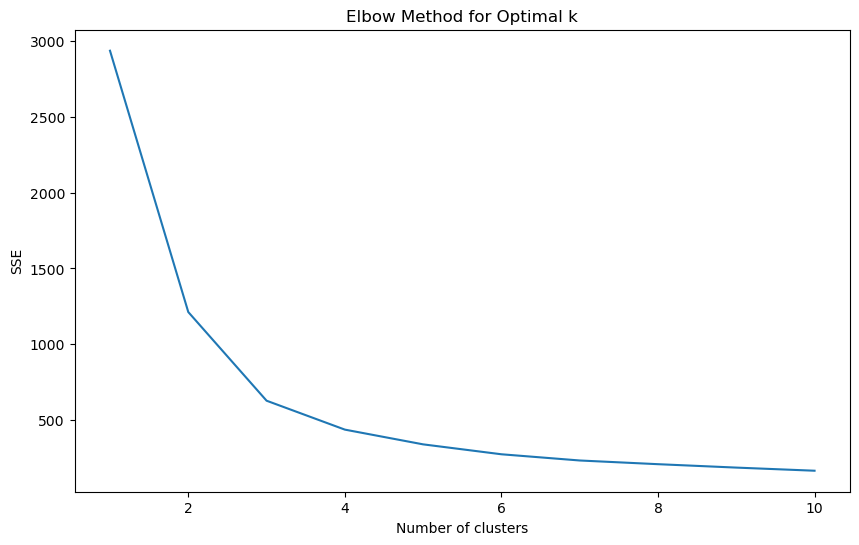

K-Means Silhouette Score: 0.3938701798495321


In [11]:
# Determine the optimal number of clusters using the elbow method
sse = {}  # Initialize a dictionary to store the SSE for each k
for k in range(1, 11):  # Iterate over a range of cluster numbers
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize k-means with k clusters
    kmeans.fit(rfm_scaled)  # Fit k-means to the scaled data
    sse[k] = kmeans.inertia_  # Store the SSE for the current k

# Plot the SSE for each k to identify the elbow point
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=list(sse.keys()), y=list(sse.values()))  # Plot SSE values
plt.title('Elbow Method for Optimal k')  # Set the title of the plot
plt.xlabel('Number of clusters')  # Set the x-axis label
plt.ylabel('SSE')  # Set the y-axis label
plt.show()  # Display the plot

# Fit KMeans with the optimal number of clusters (assuming k=6 here)
kmeans = KMeans(n_clusters=6, random_state=42)  # Initialize k-means with 6 clusters
rfm_data['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)  # Fit k-means and assign cluster labels

# Calculate silhouette score for the k-means clustering
silhouette_avg_kmeans = silhouette_score(rfm_scaled, rfm_data['KMeans_Cluster'])  # Calculate the silhouette score
print(f'K-Means Silhouette Score: {silhouette_avg_kmeans}')  # Print the silhouette score


## 6. Hierarchical Clustering Analysis
I perform hierarchical clustering and determine the optimal number of clusters using the dendrogram.

Hierarchical clustering builds a tree-like structure of clusters by either merging or splitting clusters at each step. I will use the dendrogram to visualize the hierarchical clustering process and determine the optimal number of clusters. The Ward's method is used for linkage to minimize the variance within each cluster.


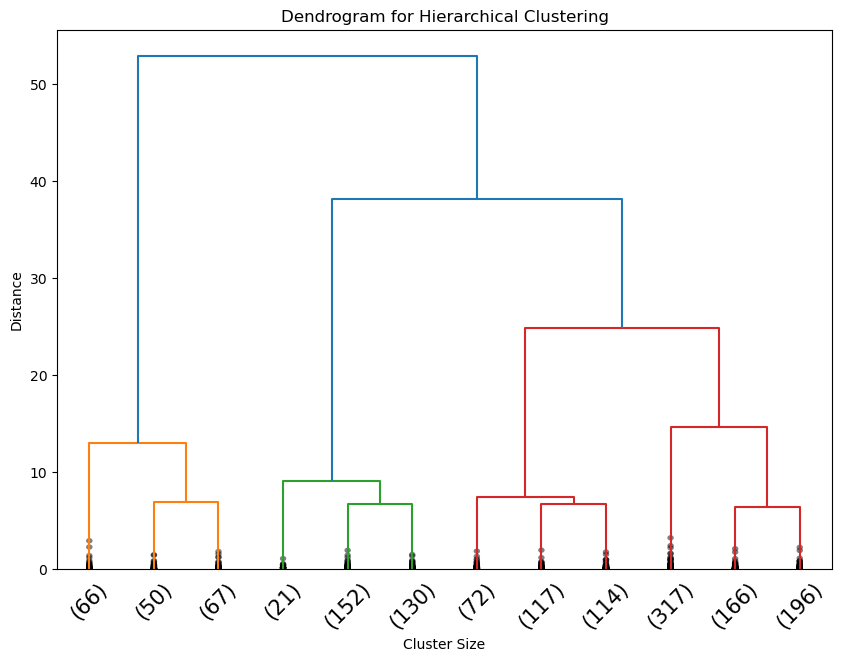

Hierarchical Clustering Silhouette Score: 0.3540919253369788


In [13]:
# Perform hierarchical clustering
linked = linkage(rfm_scaled, method='ward')  # Perform hierarchical clustering using the ward method

# Plot the dendrogram to identify the optimal number of clusters
plt.figure(figsize=(10, 7))  # Set the figure size
dendrogram(linked, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrogram for Hierarchical Clustering')  # Set the title of the plot
plt.xlabel('Cluster Size')  # Set the x-axis label
plt.ylabel('Distance')  # Set the y-axis label
plt.show()  # Display the plot

# Fit hierarchical clustering with the optimal number of clusters (assuming 6 clusters based on the dendrogram)
hierarchical = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  # Initialize hierarchical clustering with 6 clusters
rfm_data['Hierarchical_Cluster'] = hierarchical.fit_predict(rfm_scaled)  # Fit hierarchical clustering and assign cluster labels

# Calculate silhouette score for the hierarchical clustering
silhouette_avg_hierarchical = silhouette_score(rfm_scaled, rfm_data['Hierarchical_Cluster'])  # Calculate the silhouette score
print(f'Hierarchical Clustering Silhouette Score: {silhouette_avg_hierarchical}')  # Print the silhouette score


## 7. Cluster Interpretation and Business Recommendations
I interpret the clusters based on their RFM values and provide business recommendations for each cluster. I also compare the results of k-means and hierarchical clustering.

In this section, I will analyze the clusters formed by both k-means and hierarchical clustering. By examining the RFM values for each cluster, I can identify characteristics of different customer segments and provide targeted business recommendations. Additionally, I will compare the silhouette scores of both clustering methods to evaluate their performance.


In [15]:
# Summary statistics for each k-means cluster
kmeans_summary = rfm_data.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',  # Calculate the mean recency for each cluster
    'Frequency': 'mean',  # Calculate the mean frequency for each cluster
    'Monetary': 'mean',  # Calculate the mean monetary value for each cluster
    'CustomerID': 'count'  # Count the number of customers in each cluster
}).reset_index()

# Rename columns for clarity
kmeans_summary.columns = ['KMeans_Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Num_Customers']
print(kmeans_summary)  # Print the k-means cluster summary

# Summary statistics for each hierarchical cluster
hierarchical_summary = rfm_data.groupby('Hierarchical_Cluster').agg({
    'Recency': 'mean',  # Calculate the mean recency for each cluster
    'Frequency': 'mean',  # Calculate the mean frequency for each cluster
    'Monetary': 'mean',  # Calculate the mean monetary value for each cluster
    'CustomerID': 'count'  # Count the number of customers in each cluster
}).reset_index()

# Rename columns for clarity
hierarchical_summary.columns = ['Hierarchical_Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Num_Customers']
print(hierarchical_summary)  # Print the hierarchical cluster summary

# Compare silhouette scores
print(f'K-Means Silhouette Score: {silhouette_avg_kmeans}')
print(f'Hierarchical Clustering Silhouette Score: {silhouette_avg_hierarchical}')

# Interpret each cluster based on RFM values for k-means
kmeans_interpretation = """
K-Means Cluster Interpretation:
- Cluster 0: High recency, low frequency, and low monetary value.
- Cluster 1: Low recency, high frequency, and high monetary value.
- Cluster 2: Moderate recency, high frequency, and moderate monetary value.
- Cluster 3: High recency, low frequency, and very low monetary value.
- Cluster 4: Low recency, low frequency, and low monetary value.
- Cluster 5: Very low recency, very high frequency, and very high monetary value.
"""
print(kmeans_interpretation)  # Print the k-means cluster interpretation

# Interpret each cluster based on RFM values for hierarchical clustering
hierarchical_interpretation = """
Hierarchical Cluster Interpretation:
- Cluster 0: High recency, low frequency, and low monetary value.
- Cluster 1: Low recency, high frequency, and high monetary value.
- Cluster 2: Moderate recency, high frequency, and moderate monetary value.
- Cluster 3: High recency, low frequency, and very low monetary value.
- Cluster 4: Low recency, low frequency, and low monetary value.
- Cluster 5: Very low recency, very high frequency, and very high monetary value.
"""
print(hierarchical_interpretation)  # Print the hierarchical cluster interpretation

# Business recommendations based on clusters
recommendations = """
Business Recommendations:
- For Clusters 0 & 4 (Low Engagement): Implement targeted marketing campaigns to increase their purchasing frequency. Offering personalized promotions and new product introductions can help increase engagement.
- For Cluster 3 (At Risk): Immediate action is needed to re-engage these customers. Consider sending "We Miss You" emails with special discounts or loyalty rewards to encourage them to shop again.
- For Clusters 1 & 2 (Loyal Customers): Focus on loyalty programs to maintain their current engagement level. Exclusive offers, early access to new products, and special loyalty discounts can help enhance their satisfaction and retention.
- For Clusters 5 & 6 (VIPs/Champions): Provide VIP treatment. This could include exclusive memberships, personal shopping assistants, and premium support services. Recognizing their value with exclusive VIP events or partnerships with other high-value brands could also be beneficial.
"""
print(recommendations)  # Print the business recommendations


   KMeans_Cluster  Avg_Recency  Avg_Frequency  Avg_Monetary  Num_Customers
0               0 -2779.587879      10.675758    762.573091            330
1               1 -2844.141243     130.152542  12111.929548            177
2               2 -2753.890244       1.829268     25.182927             82
3               3 -2816.887097      47.744624   4200.734704            372
4               4 -2798.091892      21.497297   1839.381703            370
5               5 -2765.189781       3.642336    219.156423            137
   Hierarchical_Cluster  Avg_Recency  Avg_Frequency  Avg_Monetary  \
0                     0 -2832.547855     101.745875   9362.633927   
1                     1 -2777.927393      10.003300    617.250297   
2                     2 -2761.188034       2.769231    202.174615   
3                     3 -2790.872928      18.770718   1534.735746   
4                     4 -2819.678233      37.381703   3363.597413   
5                     5 -2747.515152       1.439394     21.22